<a href="https://colab.research.google.com/github/metalusuraimu/DL_learning/blob/master/APL/simple_rnn_ipynb_kabuka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 利用したソースコード
講義で利用したシンプルなRNNのソースコードをそのまま利用しています。


### Google　Driveのマウント



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### csvファイルの読み込み
ネットで見た記事がpandasを使っていたのでそのまま利用しました。
利用したのはs&p５００です。


In [2]:
import pandas as pd 
data= pd.read_csv('drive/My Drive/Data/sp500.csv')

ここからとりあえず動くように実装しています。。

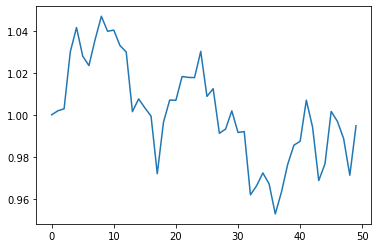

In [5]:
data = np.array(data) 
data = data.reshape(-1) #元のソースコードに型を合わせる


data = data / data[0] #正規化
data = data[0:50] #50日分のデータ取り出し
plt.plot(data)

## データの前処理
入力、正解データをRNNに適した形に整えます。  
時系列から次の値を予測できるように、時系列を入力として正解はその1つ後の値とします。 

In [6]:
import torch
from torch.utils.data import DataLoader

n_time = 10  # 時系列の数
n_sample = len(data)-n_time  # サンプル数

input_data = np.zeros((n_sample, n_time, 1))  # 入力
correct_data = np.zeros((n_sample, 1))  # 正解
for i in range(n_sample):
    input_data[i] = data[i:i+n_time].reshape(-1, 1)
    correct_data[i] = data[i+n_time:i+n_time+1]  # 正解は入力よりも一つ後

input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成

train_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # DataLoaderの設定

## モデルの構築
`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
RNNは`nn.RNN`を使って実装することができます。

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(  # RNN層
            input_size=1,  # 入力サイズ
            hidden_size=64,  # ニューロン数
            batch_first=True,  # 入力を (バッチサイズ, 時系列の数, 入力の数) にする
        )
        self.fc = nn.Linear(64, 1)  # 全結合層

    def forward(self, x):
        y_rnn, h = self.rnn(x, None)  # hは次の時刻に渡される値、 Noneでその初期値が0に
        y = self.fc(y_rnn[:, -1, :])  # yは最後の時刻の出力
        return y

net = Net()
print(net)

Net(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  
訓練したモデルを使い、直近の時系列を使った予測結果を次々と時系列に加えていくことにより、曲線が生成されます。  
学習が進むとともに次第にサインカーブが生成されるようになりますが、曲線は一定のエポック間隔でグラフとして描画されます。  

Epoch: 0 Loss_Train: 0.7103490948677063


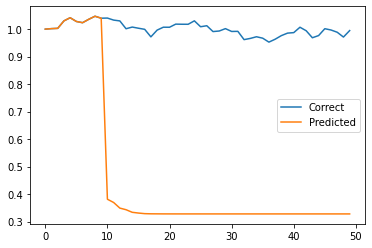

Epoch: 2 Loss_Train: 0.0692751795053482


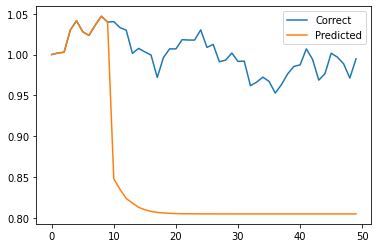

Epoch: 4 Loss_Train: 0.0023791174171492457


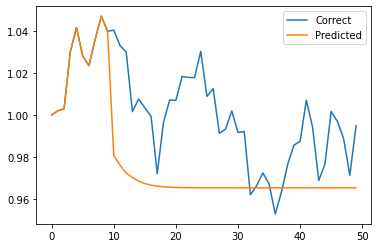

Epoch: 6 Loss_Train: 0.00037277857773005963


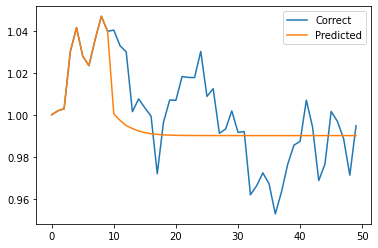

Epoch: 8 Loss_Train: 0.0003286847233539447


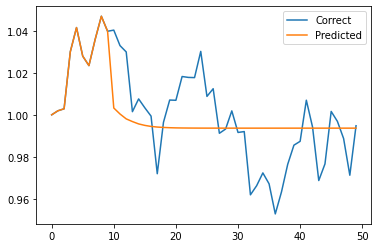

Epoch: 10 Loss_Train: 0.0003274963586591184


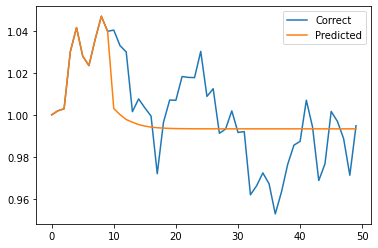

Epoch: 12 Loss_Train: 0.0003392244369024411


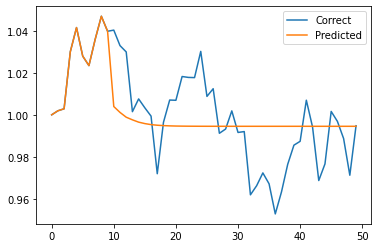

Epoch: 14 Loss_Train: 0.0003258881450165063


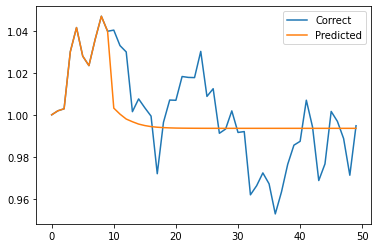

Epoch: 16 Loss_Train: 0.0003268726548412815


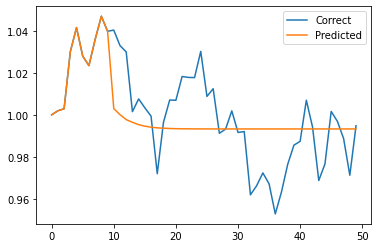

Epoch: 18 Loss_Train: 0.00032810447446536274


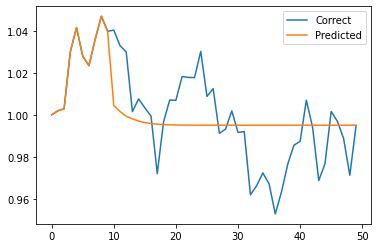

Epoch: 20 Loss_Train: 0.0003366303048096597


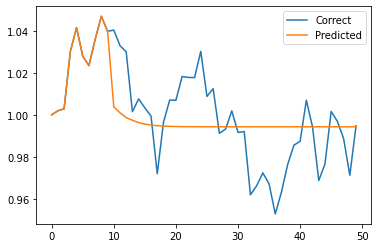

Epoch: 22 Loss_Train: 0.00032933852635324


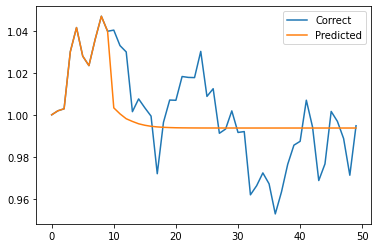

Epoch: 24 Loss_Train: 0.0003393543709535152


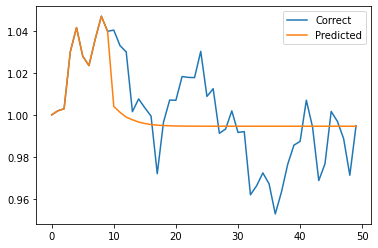

Epoch: 26 Loss_Train: 0.0003348088212078437


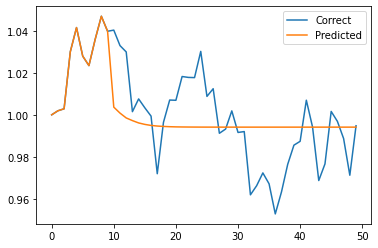

Epoch: 28 Loss_Train: 0.00032628682092763486


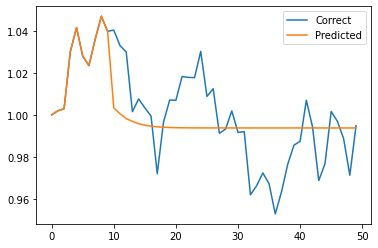

Epoch: 30 Loss_Train: 0.0003299857984529808


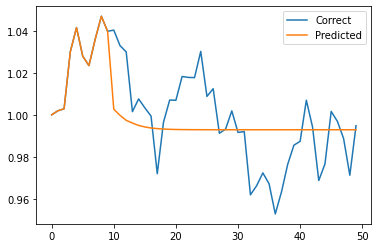

Epoch: 32 Loss_Train: 0.00032666030456312


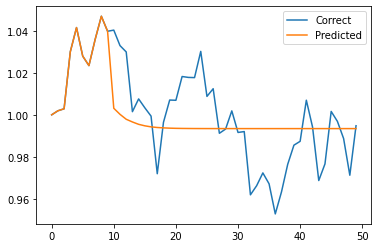

Epoch: 34 Loss_Train: 0.0003317119058920071


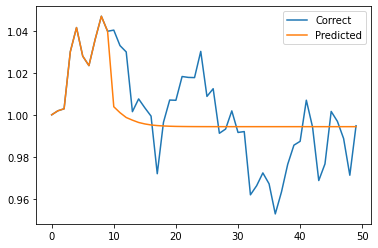

Epoch: 36 Loss_Train: 0.00032831876014824954


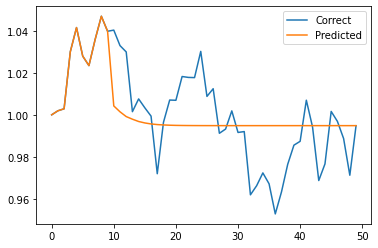

Epoch: 38 Loss_Train: 0.00032650688954163345


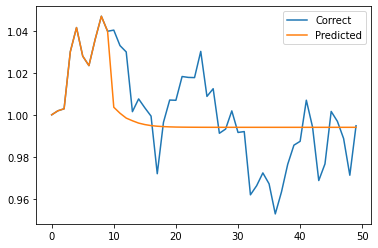

Epoch: 40 Loss_Train: 0.00033326412522001193


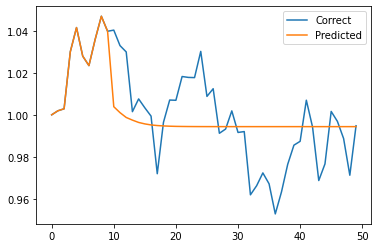

Epoch: 42 Loss_Train: 0.00032883381063584236


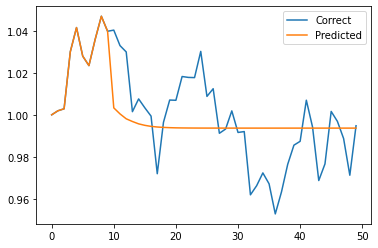

Epoch: 44 Loss_Train: 0.00033269974519498644


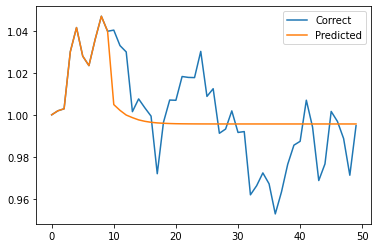

Epoch: 46 Loss_Train: 0.00033829294552560895


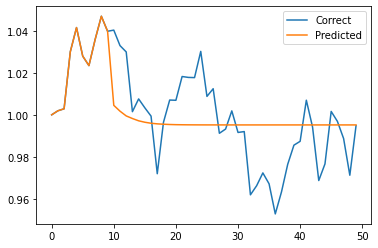

Epoch: 48 Loss_Train: 0.00033196518779732287


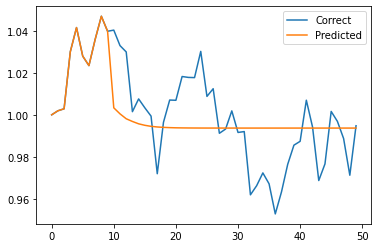

In [8]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.MSELoss()

# 最適化アルゴリズム
optimizer = optim.SGD(net.parameters(), lr=0.01)  # 学習率は0.01

# 損失のログ
record_loss_train = []

# 学習
for i in range(50):  # 50エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%2 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train)
        predicted = list(input_data[0].reshape(-1)) # 最初の入力
        for i in range(n_sample):
            x = torch.tensor(predicted[-n_time:])  # 直近の時系列を取り出す
            x = x.reshape(1, n_time, 1)  # (バッチサイズ, 時系列の数, 入力の数)
            y = net(x)
            predicted.append(y[0].item())  # 予測結果をpredictedに追加する

        plt.plot(range(len(data)), data, label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()
        

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

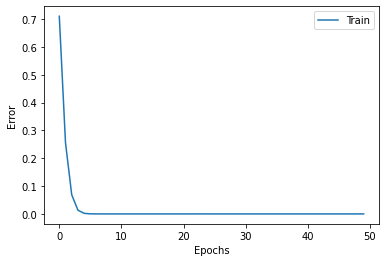

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()